# Importações e códigos


In [2]:
## importa bibliotecas
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
### Período do Bling a ser importado as Notas Fiscais
dataIni = '01/12/2020 00:00:01'
dataFim = '31/12/2020 23:59:59'
chave = 'DELETADO POR SEGURANCA'
situacao = 6,7,8
tipo = 'S'

In [10]:
def importaNotas():
  ### Celula de importação e conversão dados
  page = 1
  NotasFiscais = {}
  vendedor = []
  notasDFf = pd.DataFrame()
  while True:
      try:
          notas = {}
          dfObj2 = pd.DataFrame()
          response = requests.get(f"https://bling.com.br/Api/v2/notasfiscais/page={page}/json/&apikey={chave}&filters=dataEmissao[{dataIni} TO {dataFim}]&situacao[{situacao}]&tipo[{tipo}]")        
          if response:
              print('Request is successful for page.', page)
              #print(response)
              notas = response.json()
              List_length = len(notas['retorno']['notasfiscais'])

              dfObj2 = pd.DataFrame(notas['retorno']['notasfiscais'][0])
              dfObj2.drop(columns='notafiscal', inplace=True)

              #tabelaComissao = {'nota', 'valorNota', 'vendedor'}
              for i in range(List_length):
                  dfObj2[i] = pd.DataFrame(notas['retorno']['notasfiscais'][i])

              #dfObj2.drop(index='cfops', inplace=True)
              dfObj2.drop(index='chaveAcesso', inplace=True)
              dfObj2.drop(index='codigosRastreamento', inplace=True)
              dfObj2.drop(index='contato', inplace=True)
              dfObj2.drop(index='linkDanfe', inplace=True)
              dfObj2.drop(index='loja', inplace=True)
              dfObj2.drop(index='cnpj', inplace=True)
              dfObj2.drop(index='cliente', inplace=True)
              dfObj2.drop(index='id', inplace=True)
              dfObj2.drop(index='transporte', inplace=True)
              #dfObj2.drop(index='situacao', inplace=True)
              #dfObj2.drop(index='tipo', inplace=True)
              #dfObj2.drop(index='tipoIntegracao', inplace=True)
              #dfObj2.drop(index='numero', inplace=True)
              dfObj2.drop(index='numeroPedidoLoja', inplace=True)
              dfObj2.drop(index='serie', inplace=True)
              #dfObj2.drop(index='transporte', inplace=True)
              dfObj2.drop(index='xml', inplace=True)
              
              dfObjT = pd.DataFrame()
              dfObjT = dfObj2.transpose()

              dfObjT[["valorNota"]] = dfObjT[["valorNota"]].apply(pd.to_numeric)
              dfObjT[["dataEmissao"]] = dfObjT[["dataEmissao"]].apply(pd.to_datetime)

              notasDFf = notasDFf.append(dfObjT, ignore_index = True) 
              notasDFf['cfops'] = notasDFf['cfops'].astype(str)
              # start stop and step variables 
              #start, stop, step = 0, 6, 2
              #notasDFf['cfops'] = notasDFf['cfops'].str.slice(start, stop, step) 
              notasDFf.tail(1)
              page += 1
          else:
              print('Request returned an error for page.', page)
      except:
          break
  print('done')
  return notasDFf

def selecionaCFOPS(cfops, notas):
  appended_data = []
  ### Celula para excluir CFOPs que não interessam
  for i in cfops:
    try:
      appended_data.append(notas[notas['cfops'].str.contains(i)])
      # see pd.concat documentation for more info
      appended_data
    except:
        print (i, 'erro')
        continue
  appended_data = pd.concat(appended_data)
  return appended_data

def eliminaNotas(cfops, notas):
  ### Celula para excluir CFOPs que não interessam
  for i in cfops:
    try:
      notas = notas[~notas['cfops'].str.contains(i)]
    except:
      print (i, 'erro')
      continue
  return notas

def relatorioVendedor(notasDFf):
  global vendedor
  ### Relatorio por Vendedor --- Atenção para observar Notas sem Vendedor
  #notasDFf[notasDFf['vendedor'] == 'Raquel']['numero']
  vendedor = notasDFf.groupby('vendedor')['valorNota'].sum()
  return vendedor

### Lista de vendedores de cada negócio
listaIdentlab = ['Raquel','Rebeca Menezes', 'Bárbara Alves Feliciano', 'Cleusa Gama', 'JERRY ADRIANI ORRIGO - ME', 'Leandro Goldstein', 'identlab', 'leo gold', 'ZZAG','RODRIGO MENEGHINI','ROSEMERE PEREIRA PNHO']
#listaMarketPlace = ['Amazon', 'B2W - Portal de Vendas', 'Carrefour', 'Magalu', 'Mercado Livre', 'Olist']
#listaInverto = ['Andre Paiva', 'Inverto Loja', 'Laerte', 'Mauricio', 'VERA LUCIA DE SOUZA', 'Vilma Britto de Souza', 'BROKER', 'Marilda Buzzo de Lima', 'Padovani Representações Ltda', 'Pedro Evandro de Souza', 'Thamiris Santos', 'Rafaela da Silva Santos', 'BR NEGOCIOS E REPRESENTAÇÕES LTDA']
naoIdentificado = ['', ' ']
#negocios = { 'identlab' : listaIdentlab, 'marketplace' : listaMarketPlace, 'invertoAtacado' : listaInverto, 'naoIdentificado' : naoIdentificado}
negocios = { 'identlab' : listaIdentlab}
cfopsDiversos = ['1411', '2411','5411','5202','5901','5904','5910','6910','5911','6911','5912','6912','5502','5949','6949','5915','6915','5917','6917','5202','6202','6502','7102']
cfopsExportacao = ['6502','7102']
cfopsDevolucao = ['1411', '2411', '5411']

def vendasNegocios(notas):
  global negocios
  notas['negocios'] = ''
  for j in negocios.keys():
    for i in negocios[j]:
      try:
          notas.loc[notas['vendedor'] == i, 'negocios'] = j
      except:
          print (i, '- sem vendas no período')
          continue
  return notas

def relVendasNegocio(negocio,vendedor):
  ### Da tabela de vendedores - calcula vendas da INVERTO LOJAS identificando vendedores sem vendas no período

  vendas = 0
  for i in negocio:
      try:
          vendas = vendas + vendedor[i]
      except:
          print (i, '- sem vendas no período')
          continue
  return vendas

def campoNomeUf(vendas):
  nome=[]
  uf=[]
  mes=[]
  transporte=[]
  vendas['dataEmissao'] = vendas['dataEmissao'].astype(str)
  for i in vendas.index:
    nome.append(vendas['cliente'][i]['nome'])
    uf.append(vendas['cliente'][i]['uf'])
    mes.append(vendas['dataEmissao'][i][:7].replace('-',''))
    try:
      if vendas['transporte'][i]['servico_correios']:
        transporte.append(vendas['transporte'][i]['servico_correios'])
    except Exception:
      transporte.append('sem informacao')
      pass
    if vendas['vendedor'][i] == '':
      vendas['vendedor'][i] = vendas['tipoIntegracao'][i]
  vendas['nome'] = nome
  vendas['uf'] = uf
  vendas['mes'] = mes
  vendas['transporte'] = transporte
  vendas.drop(columns=['cfops','cnpj','situacao','tipo','tipoIntegracao'], inplace=True)
  return vendas

In [7]:
notas = importaNotas()
exportacao = selecionaCFOPS(cfopsExportacao, notas)
nacional = eliminaNotas(cfopsDiversos, notas)
nacional = vendasNegocios(nacional)
#notasDFf.head(5)
nacional.head(5)

Request is successful for page. 1
Request is successful for page. 2
Request is successful for page. 3
Request is successful for page. 4
Request is successful for page. 5
Request is successful for page. 6
Request is successful for page. 7
Request is successful for page. 8
Request is successful for page. 9
Request is successful for page. 10
done


,cfops,dataEmissao,numero,situacao,tipo,tipoIntegracao,valorNota,vendedor,negocios
0,['5405'],2020-12-01 09:05:38,057139,Emitida DANFE,S,SkyHub,51.41,B2W - Portal de Vendas,
1,['5405'],2020-12-01 09:06:12,057140,Emitida DANFE,S,SkyHub,37.17,B2W - Portal de Vendas,
2,['5405'],2020-12-01 09:06:53,057141,Emitida DANFE,S,SkyHub,32.49,B2W - Portal de Vendas,
3,['5405'],2020-12-01 09:07:02,057142,Emitida DANFE,S,SkyHub,33.70,B2W - Portal de Vendas,
4,['6108'],2020-12-01 09:07:45,057143,Emitida DANFE,S,SkyHub,44.43,B2W - Portal de Vendas,


# Dados Básicos

In [12]:
### Relatorio por vendedor simples
relatorioVendedor(nacional)
vendedor.to_frame()

,valorNota
vendedor,
,4089.61
Amazon,34.79
Andre Paiva,9060.36
B2W - Portal de Vendas,22292.32
BR NEGOCIOS E REPRESENTAÇÕES LTDA,36398.40
Bárbara Alves,115.00
Cleusa Gama,14244.18
Inverto Loja,304176.74
Leandro Goldstein,4861.70


In [ ]:
### Para comparar se o valor do vendedor bate com o da integração
from google.colab import drive
drive.mount('drive') 
notasInverto = notasInverto[['numero','dataEmissao','nome','valorNota','vendedor','mes','uf','negocios','transporte']]
#notasInverto[notasInverto['negocios'] == 'identlab'].to_excel('inverto.xls')
notasInverto.to_excel('inverto.xls')
!cp inverto.xls "drive/My Drive/inverto/RelatoriosVendas/"

Mounted at drive


In [13]:
### Para filtra por integração para verificar
nacional[nacional['tipoIntegracao'] == 'Api']
#notasDFf[notasDFf['valorNota'] == 32.98]

,cfops,dataEmissao,numero,situacao,tipo,tipoIntegracao,valorNota,vendedor,negocios
39,['5102'],2020-12-01 15:18:46,057180,Emitida DANFE,S,Api,579.00,Andre Paiva,
40,['5102'],2020-12-01 15:25:21,057181,Emitida DANFE,S,Api,500.00,Cleusa Gama,identlab
79,"['5405', '5405']",2020-12-02 13:22:23,057220,Emitida DANFE,S,Api,356.00,Thamiris Santos,
114,['5102'],2020-12-03 10:57:09,057256,Emitida DANFE,S,Api,357.00,ROSEMERE PEREIRA PINHO,
130,"['5102', '5102', '5102', '5102']",2020-12-03 14:57:53,057272,Emitida DANFE,S,Api,178.40,Raquel,identlab
...,...,...,...,...,...,...,...,...,...
832,"['6108', '6108', '6108', '6108']",2020-12-29 10:49:44,057991,Emitida DANFE,S,Api,511.17,Rebeca Menezes,identlab
834,['6102'],2020-12-29 11:17:16,057993,Emitida DANFE,S,Api,1194.70,Leandro Goldstein,identlab
841,"['6102', '6102', '6102']",2020-12-29 13:36:03,057990,Emitida DANFE,S,Api,1095.00,Leandro Goldstein,identlab
842,"['6102', '6102', '6102', '6102', '6102', '6102...",2020-12-29 14:32:41,058000,Emitida DANFE,S,Api,956.14,ROSEMERE PEREIRA PINHO,


In [14]:
### Lista Sem vendedores no período Importado
#notasDFf.where(notasDFf['vendedor'] == '').dropna()
vendedorfiltro = ''
nacional[nacional['vendedor'] == vendedorfiltro]


,cfops,dataEmissao,numero,situacao,tipo,tipoIntegracao,valorNota,vendedor,negocios
50,['5405'],2020-12-01 16:50:38,057190,Emitida DANFE,S,MercadoLivre,31.80,,
228,['6108'],2020-12-07 11:36:45,057377,Emitida DANFE,S,MercadoLivre,151.18,,
267,['5405'],2020-12-07 17:22:43,057411,Emitida DANFE,S,MercadoLivre,65.30,,
377,['5405'],2020-12-11 14:41:26,057525,Emitida DANFE,S,MercadoLivre,34.89,,
378,['5405'],2020-12-11 14:41:34,057526,Emitida DANFE,S,MercadoLivre,46.90,,
379,['5102'],2020-12-11 14:41:48,057527,Emitida DANFE,S,MercadoLivre,50.90,,
380,['5102'],2020-12-11 14:42:11,057528,Emitida DANFE,S,MercadoLivre,50.90,,
381,['5405'],2020-12-11 14:42:28,057529,Emitida DANFE,S,MercadoLivre,83.88,,
382,['5405'],2020-12-11 14:42:51,057530,Emitida DANFE,S,MercadoLivre,27.89,,
383,['6108'],2020-12-11 14:43:02,057531,Emitida DANFE,S,MercadoLivre,57.86,,


In [15]:
identlab = relVendasNegocio(listaIdentlab,vendedor)
identlab

Bárbara Alves Feliciano - sem vendas no período
JERRY ADRIANI ORRIGO - ME - sem vendas no período
leo gold - sem vendas no período
ZZAG - sem vendas no período
ROSEMERE PEREIRA PNHO - sem vendas no período


113521.20000000001

In [18]:
semVendedor = relVendasNegocio(naoIdentificado,vendedor)
semVendedor

  - sem vendas no período


4089.61

In [19]:
### Total de vendas no período para checagem abaixo
nacional['valorNota'].sum()

548190.45

In [28]:
### Total de vendas somado por negócio 
total = identlab + semVendedor
total

117610.81000000001

In [29]:
### Total de vendas Exportação
exportacao['valorNota'].sum()

0.0

# Relatórios Gráficos

<AxesSubplot:xlabel='dataEmissao'>

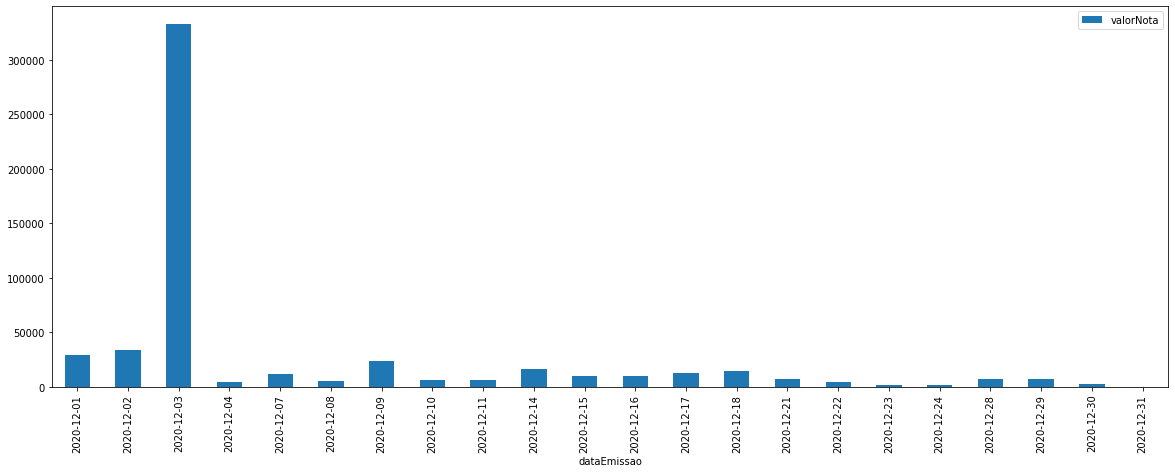

In [31]:
### Total de vendas por DIA
nacional.groupby([nacional['dataEmissao'].dt.date]).sum().plot.bar(stacked=True, figsize=(20,7))


<AxesSubplot:xlabel='dataEmissao'>

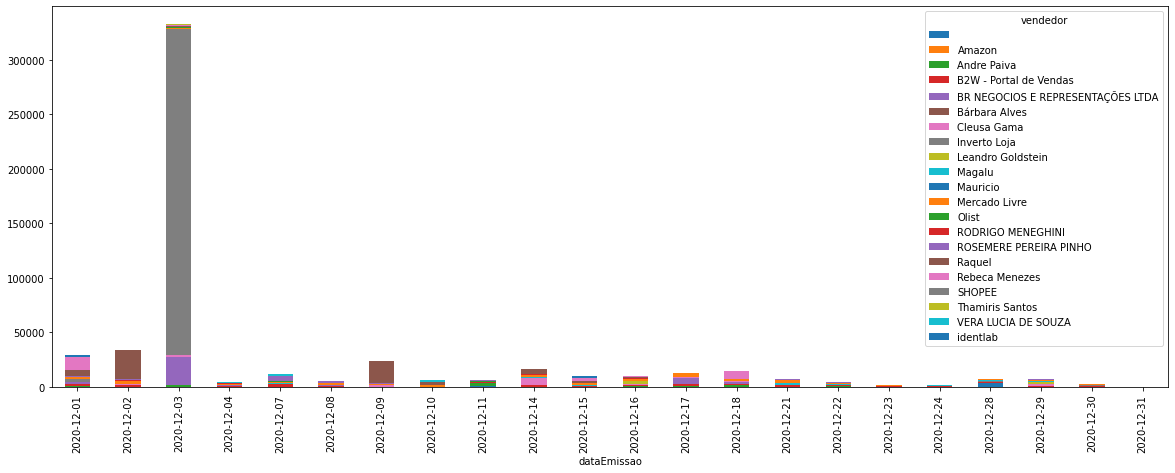

In [32]:
### Diário por vendedor / Faturamento
pivot_df = pd.pivot_table(nacional, index=nacional['dataEmissao'].dt.date, columns=['vendedor'], values='valorNota', aggfunc=np.sum)
pivot_df.plot.bar(stacked=True, figsize=(20,7))

<AxesSubplot:xlabel='dataEmissao'>

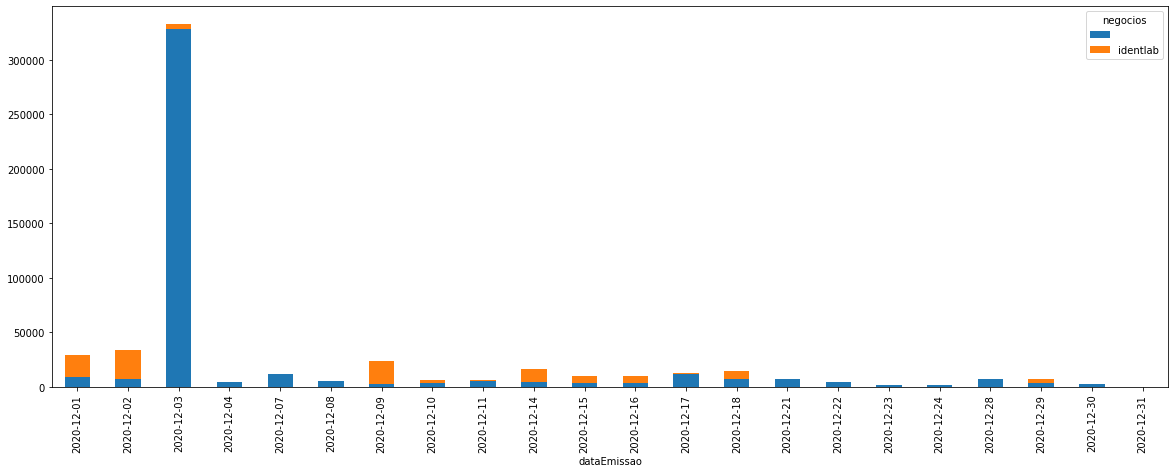

In [33]:
### Diário por Negócio / Faturamento
pivot_df = pd.pivot_table(nacional, index=nacional['dataEmissao'].dt.date, columns=['negocios'], values='valorNota', aggfunc=np.sum)
pivot_df.plot.bar(stacked=True, figsize=(20,7))


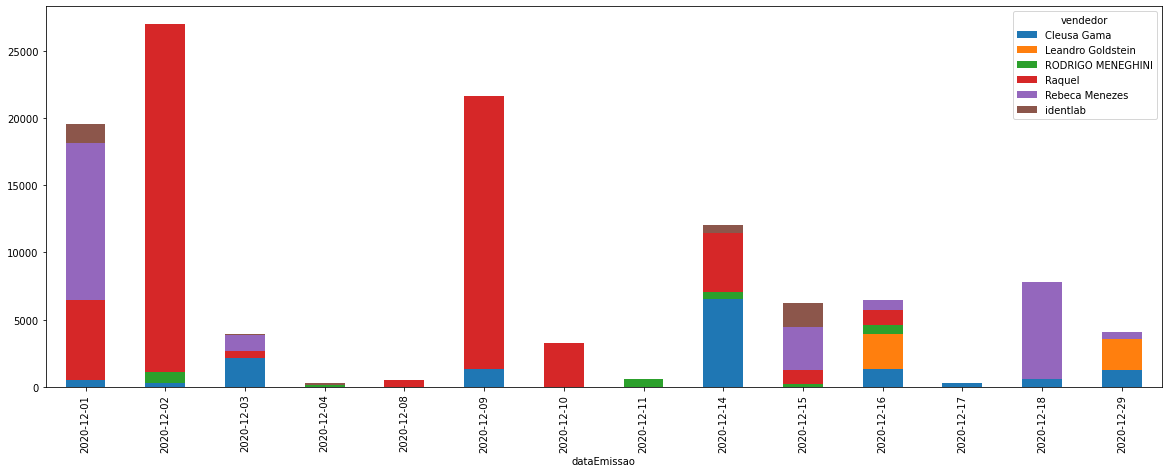

In [34]:
#Relatorios Diário por vendedor por faturamento separado por negócio
def graficosI(negocios, notas, visualiza):
  for j in negocios.keys():
    try:
      if visualiza == 'soma':
        pivot_df = pd.pivot_table(notas[notas.negocios == j], index=notas['dataEmissao'].dt.date, columns=['vendedor'], values='valorNota', aggfunc=np.sum)
      elif visualiza == 'conta':
        pivot_df = pd.pivot_table(notas[notas.negocios == j], index=notas['dataEmissao'].dt.date, columns=['vendedor'], values='valorNota', aggfunc=np.count_nonzero)
      pivot_df.plot.bar(stacked=True, figsize=(20,7))
    except:
      continue
### visualiza 'soma' ou 'conta'
visualiza = 'soma'
graficosI(negocios, nacional, visualiza)

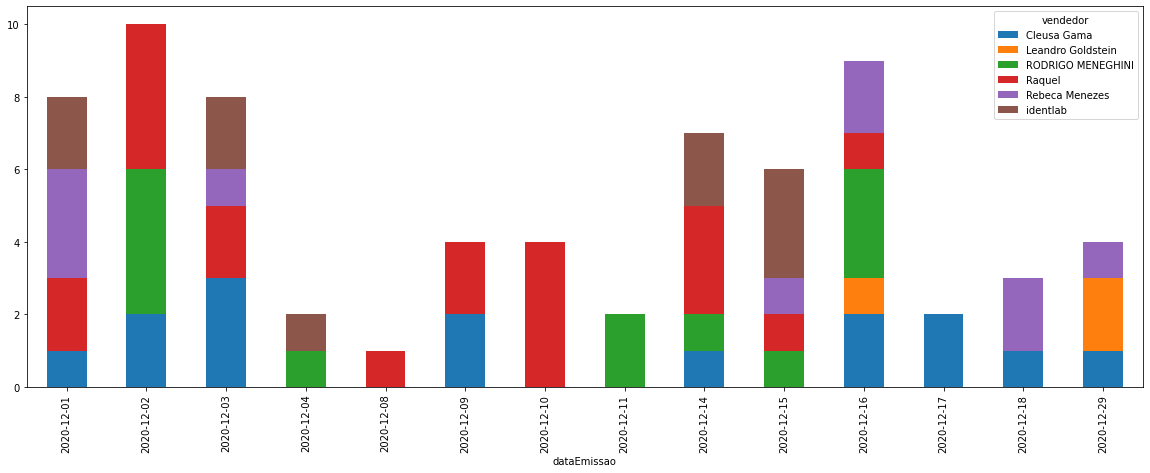

In [35]:
#Relatorios Diário por vendedor por numero de pedidos separado por negócio
### visualiza 'soma' ou 'conta'
visualiza = 'conta'
graficosI(negocios, nacional, visualiza)

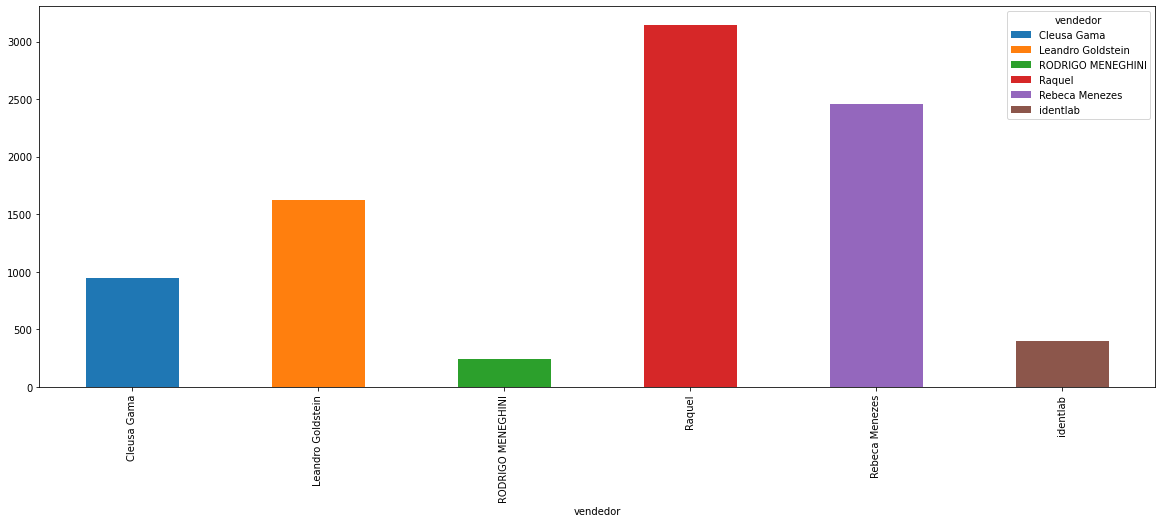

In [36]:
#Ticket Médio por vendedor separado por negócio
for j in negocios.keys():
  try:
    pivot_dfF = pd.pivot_table(nacional[nacional.negocios == j], index=nacional['vendedor'], columns=['vendedor'], values='valorNota', aggfunc=np.sum)
    pivot_dfC = pd.pivot_table(nacional[nacional.negocios == j], index=nacional['vendedor'], columns=['vendedor'], values='valorNota', aggfunc=np.count_nonzero)
    pivot_df = pivot_dfF / pivot_dfC
    pivot_df.plot.bar(stacked=True, figsize=(20,7))
  except:
    print("Ops... algo deu errado... deve faltar algum dado")

# Imposto

In [37]:

listaCFOP = ['5102', '5106', '5405', '5901','5910','6102', '6106', '6108', '6403','6202','6910']


In [38]:
def imposto(notasImposto):
  total = 0
  imposto = 0
  for i in listaCFOP:
    imposto = notasImposto['valorNota'][notasImposto['cfops'].str.contains(i)].sum()
    selRows = notasImposto['valorNota'][notasImposto['cfops'].str.contains(i)].index
    notasImposto = notasImposto.drop(selRows, axis=0)
    print("TOTAL CFOP ", i, " ",imposto)
    #print(imposto)
    total = total + imposto
  print("TOTAL: ", total)
  return

In [39]:
imposto(notas)

TOTAL CFOP  5102   147091.11000000002
TOTAL CFOP  5106   0.0
TOTAL CFOP  5405   25474.96
TOTAL CFOP  5901   0.0
TOTAL CFOP  5910   3005.75
TOTAL CFOP  6102   32026.33
TOTAL CFOP  6106   0.0
TOTAL CFOP  6108   43448.05
TOTAL CFOP  6403   0.0
TOTAL CFOP  6202   0.0
TOTAL CFOP  6910   393.75
TOTAL:  251439.95


In [40]:
nacional['valorNota'].sum()

548190.45